<a href="https://colab.research.google.com/github/h0806449f/PyTorch/blob/main/DB_04_custom_datasets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **=== 0. Pytorch Domain Libraries ===**
1. Info
    https://pytorch.org/blog/new-library-updates-in-pytorch-2.0/
2. To do list
    1. torch vision : https://pytorch.org/vision/stable/
    2. torch audio : https://pytorch.org/audio/stable/
    3. torch rec : https://pytorch.org/torchrec/

In [1]:
import torch
from torch import nn

torch.__version__

'2.0.1+cu118'

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# **=== 1. Get data ===**
1. 原資料集 : Food 101
    1. 101 classes
    2. 1000 images
2. 截取部分資料及內容 :
    1. https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/04_custom_data_creation.ipynb
    2. 3 classes
    3. 10% - 20% images of food 101

In [3]:
import requests
import zipfile
from pathlib import Path

# 設置資料路徑
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# 判斷資料夾存在與否
if image_path.is_dir():
    print(f"{image_path} directory already exist, skipping download")
else:
    print(f"{image_path} doesn't exist, creating")
    image_path.mkdir(parents=True, exist_ok=True)

# 下載壓縮檔
with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
    f.write(request.content)

# 解壓縮
with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
    print("Unzipping the file")
    zip_ref.extractall(image_path)

data/pizza_steak_sushi doesn't exist, creating
Unzipping the file


# 1.1 檢視資料結構
1. 注意資料夾與資料結構
2. train
    3 floders of different type images
3. test
    3 floders of different type images

In [4]:
# Walk function
import os

def walk_through_dir(dir_path):
    """Walk through dir_path, returning the content in it"""

    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} dirs and {len(filenames)} images in {dirpath}.")

In [5]:
# 資料結構
walk_through_dir(image_path)

There are 2 dirs and 0 images in data/pizza_steak_sushi.
There are 3 dirs and 0 images in data/pizza_steak_sushi/train.
There are 0 dirs and 72 images in data/pizza_steak_sushi/train/sushi.
There are 0 dirs and 78 images in data/pizza_steak_sushi/train/pizza.
There are 0 dirs and 75 images in data/pizza_steak_sushi/train/steak.
There are 3 dirs and 0 images in data/pizza_steak_sushi/test.
There are 0 dirs and 31 images in data/pizza_steak_sushi/test/sushi.
There are 0 dirs and 25 images in data/pizza_steak_sushi/test/pizza.
There are 0 dirs and 19 images in data/pizza_steak_sushi/test/steak.


In [6]:
# 圖片位置
print(image_path)

data/pizza_steak_sushi


In [7]:
# Setup training and testing paths

train_dir = image_path / "train"
test_dir = image_path / "test"

print(f"train 路徑: {train_dir}")
print(f"test 路徑: {test_dir}")

train 路徑: data/pizza_steak_sushi/train
test 路徑: data/pizza_steak_sushi/test


# 1.2 檢視圖片

1. Get all of the image "path"
2. Pick random image path  (`random.choice()`)
3. Get image class name  (`pathlib.Path.parent.stem`)
4. Open image  (`PIL`)
5. Show image and print info

In [8]:
# 1. Get all image path
import random
from PIL import Image

# 設置 random seed
random.seed(42)

# "path" list
# image_path -> content/data/pizza_steak_sushi

image_path_list = list(image_path.glob("*/*/*.jpg"))  # 注意層數

In [9]:
# 2. Random pick
random_image_path = random.choice(image_path_list)
random_image_path

PosixPath('data/pizza_steak_sushi/train/sushi/390178.jpg')

In [10]:
# 3. Get image class name
image_class = random_image_path.parent.stem
image_class

'sushi'

In [11]:
# 額外 : 如要選取路經中的檔案名稱
file_name = random_image_path.name
file_name

'390178.jpg'

In [12]:
# 4. Show image
img = Image.open(random_image_path)

圖片路徑: data/pizza_steak_sushi/train/sushi/390178.jpg
圖片類別: sushi | 名稱: 390178.jpg
高: 384 | 寬: 512


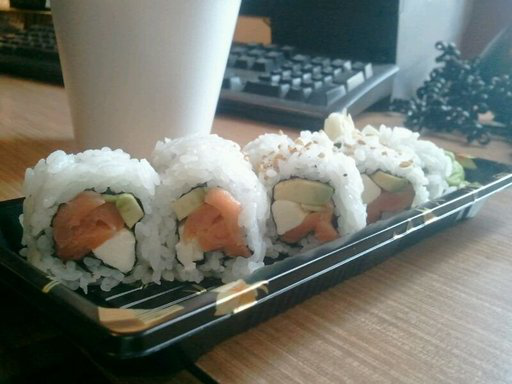

In [13]:
# 5. Show image and image_info

print(f"圖片路徑: {random_image_path}")
print(f"圖片類別: {image_class} | 名稱: {file_name}")
print(f"高: {img.height} | 寬: {img.width}")
img

# 1.2.1 檢視圖片 -> Matplotlib

(-0.5, 511.5, 383.5, -0.5)

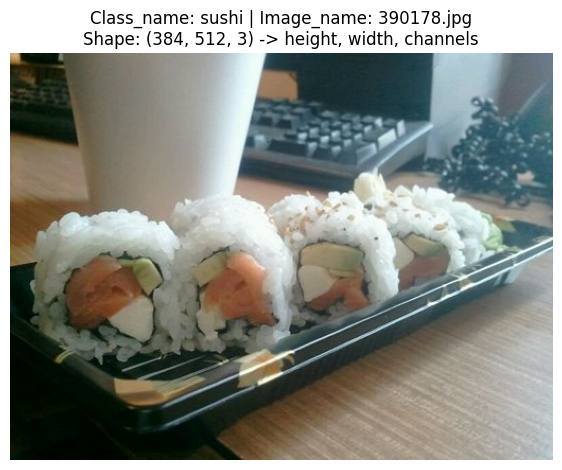

In [14]:
import numpy as np
import matplotlib.pyplot as plt

# Turn image to array
img_array = np.asarray(img)

# Plot the image
plt.figure(figsize=(7, 7))
plt.imshow(img_array)
plt.title(f"Class_name: {image_class} | Image_name: {file_name}\nShape: {img_array.shape} -> height, width, channels")
plt.axis("off")

# **=== 2. 資料預處理 & 資料增強===**

PyTorch 需要的資料型態 **tensor**
1. 將所有圖片都轉成 tensor
2. `torch.utils.data.Dataset`
    自定義資料集
3. `torch.utils.data.DataLoader`
    可迭代, 將資料及內容以批次的方式提供出來
4. 數據增強
    https://pytorch.org/vision/master/transforms.html
    1. `transforms.Resize(size)`
    2. `transforms.RandomHorizontalFlip(p)`
    3. `transforms.RandomVerticalFlip(p)`
    4. `transforms.RandomRotation(degrees)`
    5. `transforms.ColorJitter(brightness, contrast, saturation, hue)`
    對圖像的亮度、對比度、飽和度和色調進行隨機調整。
    6. `transforms.RandomCrop(size)`
    隨機從圖像中裁剪出指定大小的區域。
    7. `transforms.Normalize(mean, std)`



In [15]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# transforms -> convert PIL or numpy image to tensor

In [16]:
# Write a "transform" for image
data_transform = transforms.Compose([
    transforms.Resize(size = (64, 64)),        # resize 配合CNN 所需輸入
    transforms.RandomHorizontalFlip(p = 0.5),  # 水平翻轉 -> 資料增強
    transforms.ToTensor()                      # to tensor, 會同時將數據 "歸一化"
])

In [17]:
data_transform(img).shape

torch.Size([3, 64, 64])

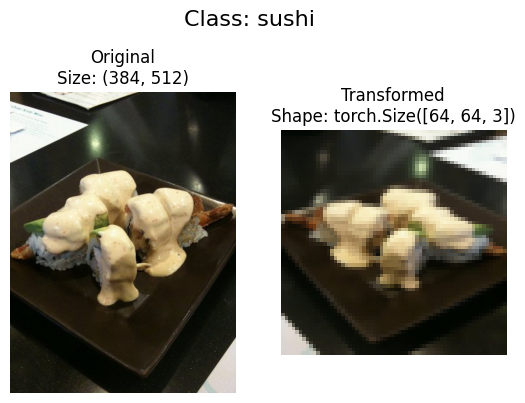

In [18]:
# 自定義一個 function 將 image_path_list 中的路徑 轉換成tensor
def plot_transformed_images(image_paths: list, transform, n=3, seed=None):
    # check seed
    if seed:
        random.seed(seed)
    # 隨機選3張圖片轉換
    random_image_paths = random.sample(image_paths, k=n)

    # subplot
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(nrows=1, ncols=2)

            # 展示原圖
            ax[0].imshow(f)
            ax[0].set_title(f"Original\nSize: {f.size}")
            ax[0].axis("off")

            # 展示轉換後的圖
            # 注意 : PIL vs matplotlib 將 channels 放在不同的位置 -> rearrange
            # permute
            transformed_image = data_transform(f).permute(1, 2, 0)
            ax[1].imshow(transformed_image)
            ax[1].set_title(f"Transformed\nShape: {transformed_image.shape}")
            ax[1].axis("off")

            # 大標
            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_paths = image_path_list,
                        transform = data_transform,
                        n=1,
                        seed=None)

# 2.1 ImageFolder

https://pytorch.org/vision/stable/generated/torchvision.datasets.ImageFolder.html
1. `torchvision.datasets.ImageFolder`
2. Dataset ImageFolder -> classes





In [25]:
# Use ImageFolder to create dataset
from torchvision import datasets

train_data = datasets.ImageFolder(root = train_dir,
                                  transform = data_transform,  # for data
                                  target_transform = None)     # for label/target

test_data = datasets.ImageFolder(root = test_dir,
                                 transform = data_transform,
                                 target_transform = None)

train_dir, train_data, test_dir, test_data

(PosixPath('data/pizza_steak_sushi/train'),
 Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 PosixPath('data/pizza_steak_sushi/test'),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [29]:
# Get class names -> list (內建的屬性)
class_list = train_data.classes
class_list

['pizza', 'steak', 'sushi']

In [30]:
# Get class names -> dict (內建的屬性)
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [33]:
# 內建屬性 : samples -> 返回路徑, 路徑label
train_data.samples[0:10]

[('data/pizza_steak_sushi/train/pizza/1008844.jpg', 0),
 ('data/pizza_steak_sushi/train/pizza/1033251.jpg', 0),
 ('data/pizza_steak_sushi/train/pizza/1044789.jpg', 0),
 ('data/pizza_steak_sushi/train/pizza/1089334.jpg', 0),
 ('data/pizza_steak_sushi/train/pizza/1105700.jpg', 0),
 ('data/pizza_steak_sushi/train/pizza/12301.jpg', 0),
 ('data/pizza_steak_sushi/train/pizza/1285298.jpg', 0),
 ('data/pizza_steak_sushi/train/pizza/138855.jpg', 0),
 ('data/pizza_steak_sushi/train/pizza/1412034.jpg', 0),
 ('data/pizza_steak_sushi/train/pizza/1524655.jpg', 0)]

# 2.1.1 ImageFolder 額外操作
1. Check info
2. Visualize

In [46]:
# train_data -> 每一個資料為tuple
# [0] -> 圖片 tensor
# [1] -> label

img, label = train_data[0][0], train_data[0][1]

print(f"Image tensor:\n{img}")
print(f"\nImage shape: {img.shape} | Image label: {class_list[label]}" )
print(f"\nImage dtype: {img.dtype} | Label dtype: {type(label)}")

Image tensor:
tensor([[[0.1137, 0.1020, 0.0980,  ..., 0.1255, 0.1216, 0.1176],
         [0.1059, 0.0980, 0.0980,  ..., 0.1294, 0.1294, 0.1294],
         [0.1020, 0.0980, 0.0941,  ..., 0.1333, 0.1333, 0.1333],
         ...,
         [0.1098, 0.1098, 0.1255,  ..., 0.1686, 0.1647, 0.1686],
         [0.0863, 0.0941, 0.1098,  ..., 0.1686, 0.1647, 0.1686],
         [0.0863, 0.0863, 0.0980,  ..., 0.1686, 0.1647, 0.1647]],

        [[0.0745, 0.0706, 0.0745,  ..., 0.0588, 0.0588, 0.0588],
         [0.0706, 0.0706, 0.0745,  ..., 0.0627, 0.0627, 0.0627],
         [0.0706, 0.0745, 0.0745,  ..., 0.0706, 0.0706, 0.0706],
         ...,
         [0.1255, 0.1333, 0.1373,  ..., 0.2510, 0.2392, 0.2392],
         [0.1098, 0.1176, 0.1255,  ..., 0.2510, 0.2392, 0.2314],
         [0.1020, 0.1059, 0.1137,  ..., 0.2431, 0.2353, 0.2275]],

        [[0.0941, 0.0902, 0.0902,  ..., 0.0196, 0.0196, 0.0196],
         [0.0902, 0.0863, 0.0902,  ..., 0.0196, 0.0157, 0.0196],
         [0.0902, 0.0902, 0.0902,  ..., 0.01

Before permute: torch.Size([3, 64, 64])
After permute: torch.Size([64, 64, 3])


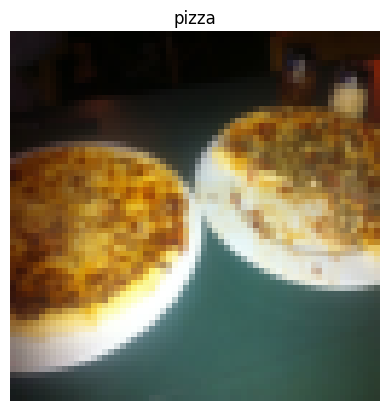

In [56]:
# Visualize
img_permute = img.permute(1, 2, 0)

# Check shapes
print(f"Before permute: {img.shape}")
print(f"After permute: {img_permute.shape}")

# Show image
plt.imshow(img_permute)
plt.title(class_list[label])
plt.gca().set_axis_off()

# **=== 3. Turn datasets to DataLoaders ===**
1. DataLoader -> iterables
2. DataLoader -> customize our batch size

In [64]:
# Trun train_data * test_data into DataLoader
import os
from torch.utils.data import DataLoader

BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

# For train
train_dataloader = DataLoader(dataset = train_data,
                              batch_size = BATCH_SIZE,
                              num_workers = NUM_WORKERS,
                              shuffle = True)  # 訓練時避免記憶

# For test
test_dataloader = DataLoader(dataset = test_data,
                             batch_size = BATCH_SIZE,
                             num_workers = NUM_WORKERS,
                             shuffle = False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7f81210cf100>,
 <torch.utils.data.dataloader.DataLoader at 0x7f81210cc1c0>)

In [65]:
# 32 * 7 = 224  / 餘 1 -> 自己一個batch
len(train_dataloader)

8

In [71]:
# 確認 train_dataloader 作用
img, label = next(iter(train_dataloader))

print(f"Image shape: {img.shape} \n-> [batch_size, color_channels, height, width]")

print(f"\nLabel shape: {label.shape} \n-> [batch_size os label index]")

Image shape: torch.Size([32, 3, 64, 64]) 
-> [batch_size, color_channels, height, width]

Label shape: torch.Size([32]) 
-> [batch_size os label index]


# test